In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from sklearn.neighbors import KNeighborsClassifier
import gc

# Importing sklearn libraries
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
!pip3 install xgboost
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import OneHotEncoder

# import lightgbm model
!pip3 install lightgbm
import lightgbm as lgb

plt.style.use('seaborn-darkgrid')
color = sns.color_palette()
%matplotlib inline

### Reading all Files individually

In [2]:
os.chdir('C:/Users/Devansh_21/Dropbox/PC/Documents/Tredence Hackathon/Retail Recommender Dataset/dataset/Raw Data')
aisle = pd.read_csv('aisles.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')
departments = pd.read_csv('departments.csv')
order_prior = pd.read_csv('order_products__prior.csv')
order_train = pd.read_csv('train.csv')
order_test = pd.read_csv('test.csv')

In [3]:
orders.set_index('order_id', inplace=True)
products.set_index('product_id', inplace=True)
aisle.set_index('aisle_id', inplace=True)
departments.set_index('department_id', inplace=True)
orders = orders.fillna(0) # Setting the NaNs to 0. i.e. sets the days since order to 0 for 1st orders

## Joining the tables together

In [4]:
# Doing inner joins on the products and the departments and the aisle by the department_id and aisle_id respectively
product_comb = products.reset_index().set_index('department_id').join(departments, how="inner")
product_comb = product_comb.reset_index().set_index('aisle_id').join(aisle, how="inner")

In [5]:
# Setting the index to 'product_id' and sorting it
product_comb = product_comb.reset_index().set_index('product_id')
product_comb.sort_index(axis=0, ascending=True, kind='quicksort', inplace=True)

In [6]:
# Doing left joins on the products and the departments and the aisle by the department_id and aisle_id respectively
product_prior_comb = order_prior.set_index('product_id').join(product_comb, how="inner")
product_prior_comb.head()

,order_id,add_to_cart_order,reordered,aisle_id,department_id,product_name,department,aisle
product_id,,,,,,,,
1,1107,7,0,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
1,5319,3,1,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
1,7540,4,1,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
1,9228,2,0,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
1,9273,30,0,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes


In [7]:
print(order_prior.head(), '\n\n')
print(product_prior_comb.head()) # added aisle id and dept id and name in order_prior table
print(order_prior.shape)

   order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
2         2        9327                  3          0
3         2       45918                  4          1
4         2       30035                  5          0 


            order_id  add_to_cart_order  reordered  aisle_id  department_id  \
product_id                                                                    
1               1107                  7          0        61             19   
1               5319                  3          1        61             19   
1               7540                  4          1        61             19   
1               9228                  2          0        61             19   
1               9273                 30          0        61             19   

                          product_name department          aisle  
product_id                                          

In [8]:
product_train_comb = order_train.set_index('product_id').join(product_comb, how="inner")
print(product_prior_comb.shape, product_train_comb.shape)
product_train_comb.head(3)

(32434489, 8) (787911, 10)


,order_id,add_to_cart_order,reordered,user_id,ID,aisle_id,department_id,product_name,department,aisle
product_id,,,,,,,,,,
1,63770,4,0,751,15342,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
1,6695,7,1,1540,87295,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
1,767323,5,0,2221,22604,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes


In [9]:
product_prior_comb.duplicated().value_counts(normalize = True)

False    1.0
dtype: float64

### Dataset Analysis

In [10]:
#orders_train_filter = (orders['eval_set']=='train')
#orders_test_filter = (orders['eval_set']=='test')
train_set = orders[orders['eval_set']=='train']
test_set = orders[orders['eval_set']=='test']


train_set.head()
#train_set.shape

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,,
1187899,1,train,11,4,8,14.0
1492625,2,train,15,1,11,30.0
2196797,5,train,5,0,11,6.0
525192,7,train,21,2,11,6.0
880375,8,train,4,1,14,10.0


In [11]:
product_train_comb.head()
product_train_comb.set_index('order_id')
product_train_comb.head()

,order_id,add_to_cart_order,reordered,user_id,ID,aisle_id,department_id,product_name,department,aisle
product_id,,,,,,,,,,
1,63770,4,0,751,15342,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
1,6695,7,1,1540,87295,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
1,767323,5,0,2221,22604,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
1,304053,3,1,9694,2852,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
1,1028477,2,0,13916,150015,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes


In [12]:
order_test.head()
order_test = order_test.rename(columns={'userID': 'user_id', 'itemID': 'product_id'})

In [13]:
product_test_comb = order_test.set_index('product_id').join(product_comb, how="inner")
print(product_test_comb.shape)
product_test_comb.head(3)

(260664, 9)


,order_id,add_to_cart_order,user_id,ID,aisle_id,department_id,product_name,department,aisle
product_id,,,,,,,,,
1,253400,4,21054,70466,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
1,2795830,1,29911,269483,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
1,1845054,11,31260,315191,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes


In [14]:
product_train_comb.head()

,order_id,add_to_cart_order,reordered,user_id,ID,aisle_id,department_id,product_name,department,aisle
product_id,,,,,,,,,,
1,63770,4,0,751,15342,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
1,6695,7,1,1540,87295,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
1,767323,5,0,2221,22604,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
1,304053,3,1,9694,2852,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
1,1028477,2,0,13916,150015,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes


In [15]:
train_set.head()

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,,
1187899,1,train,11,4,8,14.0
1492625,2,train,15,1,11,30.0
2196797,5,train,5,0,11,6.0
525192,7,train,21,2,11,6.0
880375,8,train,4,1,14,10.0


In [16]:
product_train_comb.head()

,order_id,add_to_cart_order,reordered,user_id,ID,aisle_id,department_id,product_name,department,aisle
product_id,,,,,,,,,,
1,63770,4,0,751,15342,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
1,6695,7,1,1540,87295,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
1,767323,5,0,2221,22604,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
1,304053,3,1,9694,2852,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
1,1028477,2,0,13916,150015,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes


In [17]:
product_train_comb.reset_index(inplace=True)
product_train_comb.set_index('order_id')

orders_product_train_comb = pd.merge(train_set,product_train_comb, on= ['order_id', 'user_id'],how="inner")
orders_product_train_comb.head()

product_test_comb.reset_index(inplace=True)
product_train_comb.set_index('order_id')

orders_product_test_comb = pd.merge(test_set,product_test_comb, on= ['order_id', 'user_id'],how="inner")
orders_product_test_comb.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,ID,aisle_id,department_id,product_name,department,aisle


In [18]:
orders_product_train_comb.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,ID,aisle_id,department_id,product_name,department,aisle
0,1187899,1,train,11,4,8,14.0,196,1,1,10,77,7,Soda,beverages,soft drinks
1,1187899,1,train,11,4,8,14.0,10258,6,1,19,117,19,Pistachios,snacks,nuts seeds dried fruit
2,1187899,1,train,11,4,8,14.0,25133,2,1,9,21,16,Organic String Cheese,dairy eggs,packaged cheese
3,1187899,1,train,11,4,8,14.0,26405,4,1,119001,54,17,XL Pick-A-Size Paper Towel Rolls,household,paper goods
4,1187899,1,train,11,4,8,14.0,27845,9,0,14,84,16,Organic Whole Milk,dairy eggs,milk


In [19]:
product_test_comb.head()

,product_id,order_id,add_to_cart_order,user_id,ID,aisle_id,department_id,product_name,department,aisle
0,1,253400,4,21054,70466,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
1,1,2795830,1,29911,269483,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
2,1,1845054,11,31260,315191,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
3,1,1897200,24,35890,236479,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
4,1,704249,2,37537,321162,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes


In [20]:
product_test_comb.reset_index(inplace=True)

orders_product_test_comb = pd.merge(test_set,product_test_comb, on= ['order_id', 'user_id'],how="inner")
orders_product_test_comb.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,index,product_id,add_to_cart_order,ID,aisle_id,department_id,product_name,department,aisle


In [21]:
test_set.head(3)
train_set.head()

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,,
1187899,1,train,11,4,8,14.0
1492625,2,train,15,1,11,30.0
2196797,5,train,5,0,11,6.0
525192,7,train,21,2,11,6.0
880375,8,train,4,1,14,10.0


In [22]:
product_test_comb.head()

,index,product_id,order_id,add_to_cart_order,user_id,ID,aisle_id,department_id,product_name,department,aisle
0,0,1,253400,4,21054,70466,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
1,1,1,2795830,1,29911,269483,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
2,2,1,1845054,11,31260,315191,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
3,3,1,1897200,24,35890,236479,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
4,4,1,704249,2,37537,321162,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes


In [23]:
product_train_comb.head()

,product_id,order_id,add_to_cart_order,reordered,user_id,ID,aisle_id,department_id,product_name,department,aisle
0,1,63770,4,0,751,15342,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
1,1,6695,7,1,1540,87295,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
2,1,767323,5,0,2221,22604,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
3,1,304053,3,1,9694,2852,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
4,1,1028477,2,0,13916,150015,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes


In [24]:
frames = [product_train_comb,product_test_comb]

test_train_data_prod = pd.concat(frames)
test_train_data_prod.tail()

,product_id,order_id,add_to_cart_order,reordered,user_id,ID,aisle_id,department_id,product_name,department,aisle,index
260659,49683,2203552,3,NaN,190276,830490,83,4,Cucumber Kirby,produce,fresh vegetables,260659.0
260660,49686,367913,9,NaN,101169,504472,112,3,Artisan Baguette,bakery,bread,260660.0
260661,49686,133700,5,NaN,174261,855741,112,3,Artisan Baguette,bakery,bread,260661.0
260662,49687,1092104,1,NaN,137573,1306083,41,8,Smartblend Healthy Metabolism Dry Cat Food,pets,cat food care,260662.0
260663,49688,2986153,16,NaN,40384,189435,73,11,Fresh Foaming Cleanser,personal care,facial care,260663.0


In [25]:
print(product_train_comb.shape)
print(product_test_comb.shape)
print(test_train_data_prod.shape)

(787911, 11)
(260664, 11)
(1048575, 12)


In [26]:
order_train.head(40)

,order_id,product_id,add_to_cart_order,reordered,user_id,ID
0,1187899,27845,9,0,1,14
1,1187899,38928,3,1,1,2
2,1187899,39657,5,1,1,21
3,1187899,26405,4,1,1,119001
4,1187899,196,1,1,1,10
5,1187899,25133,2,1,1,9
6,1187899,10258,6,1,1,19
7,1187899,49235,10,1,1,12
8,1492625,16589,3,1,2,79
9,1492625,12007,15,0,2,54


In [27]:
train_set.head()

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,,
1187899,1,train,11,4,8,14.0
1492625,2,train,15,1,11,30.0
2196797,5,train,5,0,11,6.0
525192,7,train,21,2,11,6.0
880375,8,train,4,1,14,10.0


In [28]:
train_set.shape

(131209, 6)

In [29]:
test_train_final = pd.merge(train_set,test_train_data_prod, on= ['order_id', 'user_id'],how="inner")

In [30]:
test_train_final.drop(columns = 'index', inplace = True)
test_train_final.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,ID,aisle_id,department_id,product_name,department,aisle
0,1187899,1,train,11,4,8,14.0,196,1,1.0,10,77,7,Soda,beverages,soft drinks
1,1187899,1,train,11,4,8,14.0,10258,6,1.0,19,117,19,Pistachios,snacks,nuts seeds dried fruit
2,1187899,1,train,11,4,8,14.0,25133,2,1.0,9,21,16,Organic String Cheese,dairy eggs,packaged cheese
3,1187899,1,train,11,4,8,14.0,26405,4,1.0,119001,54,17,XL Pick-A-Size Paper Towel Rolls,household,paper goods
4,1187899,1,train,11,4,8,14.0,27845,9,0.0,14,84,16,Organic Whole Milk,dairy eggs,milk


In [31]:
print(test_train_final.shape)

(1048575, 16)


In [32]:
#keeping only train data
final_train_valid=test_train_final[(test_train_final.reordered == 1.0) | (test_train_final.reordered == 0.0)]
final_train_valid.head()
print(final_train_valid.shape)

(787911, 16)


In [33]:
final_train_valid.head(10)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,ID,aisle_id,department_id,product_name,department,aisle
0,1187899,1,train,11,4,8,14.0,196,1,1.0,10,77,7,Soda,beverages,soft drinks
1,1187899,1,train,11,4,8,14.0,10258,6,1.0,19,117,19,Pistachios,snacks,nuts seeds dried fruit
2,1187899,1,train,11,4,8,14.0,25133,2,1.0,9,21,16,Organic String Cheese,dairy eggs,packaged cheese
3,1187899,1,train,11,4,8,14.0,26405,4,1.0,119001,54,17,XL Pick-A-Size Paper Towel Rolls,household,paper goods
4,1187899,1,train,11,4,8,14.0,27845,9,0.0,14,84,16,Organic Whole Milk,dairy eggs,milk
5,1187899,1,train,11,4,8,14.0,38928,3,1.0,2,120,16,0% Greek Strained Yogurt,dairy eggs,yogurt
6,1187899,1,train,11,4,8,14.0,39657,5,1.0,21,45,19,Milk Chocolate Almonds,snacks,candy chocolate
7,1187899,1,train,11,4,8,14.0,49235,10,1.0,12,53,16,Organic Half & Half,dairy eggs,cream
11,1492625,2,train,15,1,11,30.0,1757,30,0.0,23,69,15,Organic Cashew Carrot Ginger Soup,canned goods,soup broth bouillon
12,1492625,2,train,15,1,11,30.0,2361,26,0.0,31,37,1,Mint Chip,frozen,ice cream ice


In [34]:
orders.head()

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,,
2539329,1,prior,1,2,8,0.0
2398795,1,prior,2,3,7,15.0
473747,1,prior,3,3,12,21.0
2254736,1,prior,4,4,7,29.0
431534,1,prior,5,4,15,28.0


In [35]:
orders.reset_index(inplace = True)

In [36]:
product_prior_comb = product_prior_comb.reset_index()

In [37]:
product_prior_comb.head()

,product_id,order_id,add_to_cart_order,reordered,aisle_id,department_id,product_name,department,aisle
0,1,1107,7,0,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
1,1,5319,3,1,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
2,1,7540,4,1,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
3,1,9228,2,0,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
4,1,9273,30,0,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes


In [38]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to lowest possible float without data loss
                `int64`   type to lowest possible int wihtout data loss
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].apply(pd.to_numeric, downcast='float')
    df[int_cols] = df[int_cols].apply(pd.to_numeric, downcast='integer')

    del float_cols
    del int_cols
    
    return df

In [39]:
final_train_valid = downcast_dtypes(final_train_valid)
gc.collect()

C:\Users\Devansh_21\Anaconda3\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


23

In [40]:
final_train_valid = final_train_valid.astype({"reordered": int})
final_train_valid.shape

(787911, 16)

In [41]:
order_prior_final = pd.merge(product_prior_comb,
                             orders[['order_id','user_id','days_since_prior_order','order_number','order_dow','order_hour_of_day']],
                             on='order_id', how='left')
order_prior_final.head()

,product_id,order_id,add_to_cart_order,reordered,aisle_id,department_id,product_name,department,aisle,user_id,days_since_prior_order,order_number,order_dow,order_hour_of_day
0,1,1107,7,0,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes,38259,7.0,2,1,11
1,1,5319,3,1,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes,196224,1.0,65,1,14
2,1,7540,4,1,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes,138499,7.0,8,0,14
3,1,9228,2,0,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes,79603,30.0,2,2,10
4,1,9273,30,0,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes,50005,0.0,1,1,15


In [42]:
# getting cum sum for each order id
order_prior_final=order_prior_final.sort_values(by=['user_id','order_id','product_id'])
order_prior_final['product_count_user'] = order_prior_final.groupby(['user_id', 'product_id'])['product_id'].cumsum()


order_prior_final.head(2)

,product_id,order_id,add_to_cart_order,reordered,aisle_id,department_id,product_name,department,aisle,user_id,days_since_prior_order,order_number,order_dow,order_hour_of_day,product_count_user
107829,196,431534,1,1,77,7,Soda,beverages,soft drinks,1,28.0,5,4,15,196
6002108,10258,431534,3,1,117,19,Pistachios,snacks,nuts seeds dried fruit,1,28.0,5,4,15,10258


In [43]:
order_prior_final['product_count_user'] = order_prior_final['product_count_user']/order_prior_final['product_id']
order_prior_final.head()

,product_id,order_id,add_to_cart_order,reordered,aisle_id,department_id,product_name,department,aisle,user_id,days_since_prior_order,order_number,order_dow,order_hour_of_day,product_count_user
107829,196,431534,1,1,77,7,Soda,beverages,soft drinks,1,28.0,5,4,15,1.0
6002108,10258,431534,3,1,117,19,Pistachios,snacks,nuts seeds dried fruit,1,28.0,5,4,15,1.0
6033575,10326,431534,5,0,24,4,Organic Fuji Apples,produce,fresh fruits,1,28.0,5,4,15,1.0
7188223,12427,431534,2,1,23,19,Original Beef Jerky,snacks,popcorn jerky,1,28.0,5,4,15,1.0
7596898,13176,431534,8,1,24,4,Bag of Organic Bananas,produce,fresh fruits,1,28.0,5,4,15,1.0


In [44]:
order_prior_final.head(3)

,product_id,order_id,add_to_cart_order,reordered,aisle_id,department_id,product_name,department,aisle,user_id,days_since_prior_order,order_number,order_dow,order_hour_of_day,product_count_user
107829,196,431534,1,1,77,7,Soda,beverages,soft drinks,1,28.0,5,4,15,1.0
6002108,10258,431534,3,1,117,19,Pistachios,snacks,nuts seeds dried fruit,1,28.0,5,4,15,1.0
6033575,10326,431534,5,0,24,4,Organic Fuji Apples,produce,fresh fruits,1,28.0,5,4,15,1.0


In [45]:
order_prior_final_1 = order_prior_final[['user_id','product_id','product_count_user']]
#order_prior_final_1.head(50)

In [46]:
max_product_count = pd.DataFrame(order_prior_final_1.groupby(['user_id','product_id'])['product_count_user'].max())
max_product_count.head(5)

product_count_user
user_id product_id                    
1       196                       10.0
        10258                      9.0
        10326                      1.0
        12427                     10.0
        13032                      3.0

In [47]:
max_product_count.head()

product_count_user
user_id product_id                    
1       196                       10.0
        10258                      9.0
        10326                      1.0
        12427                     10.0
        13032                      3.0

In [48]:
max_product_count.reset_index(inplace=True)
max_product_count.head(2)

,user_id,product_id,product_count_user
0,1,196,10.0
1,1,10258,9.0


In [49]:
test_train_final = pd.merge(test_train_final,max_product_count, on=['user_id', 'product_id'], how='left')
test_train_final.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,ID,aisle_id,department_id,product_name,department,aisle,product_count_user
0,1187899,1,train,11,4,8,14.0,196,1,1.0,10,77,7,Soda,beverages,soft drinks,10.0
1,1187899,1,train,11,4,8,14.0,10258,6,1.0,19,117,19,Pistachios,snacks,nuts seeds dried fruit,9.0
2,1187899,1,train,11,4,8,14.0,25133,2,1.0,9,21,16,Organic String Cheese,dairy eggs,packaged cheese,8.0
3,1187899,1,train,11,4,8,14.0,26405,4,1.0,119001,54,17,XL Pick-A-Size Paper Towel Rolls,household,paper goods,2.0
4,1187899,1,train,11,4,8,14.0,27845,9,0.0,14,84,16,Organic Whole Milk,dairy eggs,milk,NaN


In [50]:
#keeping only train data
final_train_valid=test_train_final[(test_train_final.reordered == 1.0) | (test_train_final.reordered == 0.0)]
final_train_valid.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,ID,aisle_id,department_id,product_name,department,aisle,product_count_user
0,1187899,1,train,11,4,8,14.0,196,1,1.0,10,77,7,Soda,beverages,soft drinks,10.0
1,1187899,1,train,11,4,8,14.0,10258,6,1.0,19,117,19,Pistachios,snacks,nuts seeds dried fruit,9.0
2,1187899,1,train,11,4,8,14.0,25133,2,1.0,9,21,16,Organic String Cheese,dairy eggs,packaged cheese,8.0
3,1187899,1,train,11,4,8,14.0,26405,4,1.0,119001,54,17,XL Pick-A-Size Paper Towel Rolls,household,paper goods,2.0
4,1187899,1,train,11,4,8,14.0,27845,9,0.0,14,84,16,Organic Whole Milk,dairy eggs,milk,NaN


In [51]:
final_train_valid['product_count_user'].value_counts()

1.0     135446
2.0      84403
3.0      58941
4.0      40034
5.0      28720
         ...  
99.0         2
96.0         2
98.0         2
93.0         2
97.0         1
Name: product_count_user, Length: 99, dtype: int64

In [52]:
gc.collect()

75

## Model Training

In [53]:
# getting count of products in each order
count=final_train_valid.groupby(['user_id', 'order_id'])['ID'].count().rename('product_count')
final_train_valid = pd.merge(final_train_valid, count, on=['user_id', 'order_id'], how='left')
final_train_valid.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,ID,aisle_id,department_id,product_name,department,aisle,product_count_user,product_count
0,1187899,1,train,11,4,8,14.0,196,1,1.0,10,77,7,Soda,beverages,soft drinks,10.0,8
1,1187899,1,train,11,4,8,14.0,10258,6,1.0,19,117,19,Pistachios,snacks,nuts seeds dried fruit,9.0,8
2,1187899,1,train,11,4,8,14.0,25133,2,1.0,9,21,16,Organic String Cheese,dairy eggs,packaged cheese,8.0,8
3,1187899,1,train,11,4,8,14.0,26405,4,1.0,119001,54,17,XL Pick-A-Size Paper Towel Rolls,household,paper goods,2.0,8
4,1187899,1,train,11,4,8,14.0,27845,9,0.0,14,84,16,Organic Whole Milk,dairy eggs,milk,NaN,8


In [54]:
# getting cum sum for each order id
final_train_valid['product_running_count'] = final_train_valid.groupby(['user_id', 'order_id'])['product_count'].cumsum()
final_train_valid.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,ID,aisle_id,department_id,product_name,department,aisle,product_count_user,product_count,product_running_count
0,1187899,1,train,11,4,8,14.0,196,1,1.0,10,77,7,Soda,beverages,soft drinks,10.0,8,8
1,1187899,1,train,11,4,8,14.0,10258,6,1.0,19,117,19,Pistachios,snacks,nuts seeds dried fruit,9.0,8,16
2,1187899,1,train,11,4,8,14.0,25133,2,1.0,9,21,16,Organic String Cheese,dairy eggs,packaged cheese,8.0,8,24
3,1187899,1,train,11,4,8,14.0,26405,4,1.0,119001,54,17,XL Pick-A-Size Paper Towel Rolls,household,paper goods,2.0,8,32
4,1187899,1,train,11,4,8,14.0,27845,9,0.0,14,84,16,Organic Whole Milk,dairy eggs,milk,NaN,8,40


In [55]:
# getting running count for each order
final_train_valid['product_running_count'] = final_train_valid['product_running_count'] / final_train_valid['product_count']
final_train_valid.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,ID,aisle_id,department_id,product_name,department,aisle,product_count_user,product_count,product_running_count
0,1187899,1,train,11,4,8,14.0,196,1,1.0,10,77,7,Soda,beverages,soft drinks,10.0,8,1.0
1,1187899,1,train,11,4,8,14.0,10258,6,1.0,19,117,19,Pistachios,snacks,nuts seeds dried fruit,9.0,8,2.0
2,1187899,1,train,11,4,8,14.0,25133,2,1.0,9,21,16,Organic String Cheese,dairy eggs,packaged cheese,8.0,8,3.0
3,1187899,1,train,11,4,8,14.0,26405,4,1.0,119001,54,17,XL Pick-A-Size Paper Towel Rolls,household,paper goods,2.0,8,4.0
4,1187899,1,train,11,4,8,14.0,27845,9,0.0,14,84,16,Organic Whole Milk,dairy eggs,milk,NaN,8,5.0


In [56]:
# getting percentage of rows
final_train_valid['product_count_percent'] = final_train_valid['product_running_count'] / final_train_valid['product_count']
final_train_valid.head(10)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,ID,aisle_id,department_id,product_name,department,aisle,product_count_user,product_count,product_running_count,product_count_percent
0,1187899,1,train,11,4,8,14.0,196,1,1.0,10,77,7,Soda,beverages,soft drinks,10.0,8,1.0,0.125000
1,1187899,1,train,11,4,8,14.0,10258,6,1.0,19,117,19,Pistachios,snacks,nuts seeds dried fruit,9.0,8,2.0,0.250000
2,1187899,1,train,11,4,8,14.0,25133,2,1.0,9,21,16,Organic String Cheese,dairy eggs,packaged cheese,8.0,8,3.0,0.375000
3,1187899,1,train,11,4,8,14.0,26405,4,1.0,119001,54,17,XL Pick-A-Size Paper Towel Rolls,household,paper goods,2.0,8,4.0,0.500000
4,1187899,1,train,11,4,8,14.0,27845,9,0.0,14,84,16,Organic Whole Milk,dairy eggs,milk,NaN,8,5.0,0.625000
5,1187899,1,train,11,4,8,14.0,38928,3,1.0,2,120,16,0% Greek Strained Yogurt,dairy eggs,yogurt,1.0,8,6.0,0.750000
6,1187899,1,train,11,4,8,14.0,39657,5,1.0,21,45,19,Milk Chocolate Almonds,snacks,candy chocolate,1.0,8,7.0,0.875000
7,1187899,1,train,11,4,8,14.0,49235,10,1.0,12,53,16,Organic Half & Half,dairy eggs,cream,2.0,8,8.0,1.000000
8,1492625,2,train,15,1,11,30.0,1757,30,0.0,23,69,15,Organic Cashew Carrot Ginger Soup,canned goods,soup broth bouillon,NaN,23,1.0,0.043478
9,1492625,2,train,15,1,11,30.0,2361,26,0.0,31,37,1,Mint Chip,frozen,ice cream ice,NaN,23,2.0,0.086957


In [57]:
final_train_valid['product_count_user'].fillna(0,inplace = True)

In [58]:
final_train_valid.head(10)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,ID,aisle_id,department_id,product_name,department,aisle,product_count_user,product_count,product_running_count,product_count_percent
0,1187899,1,train,11,4,8,14.0,196,1,1.0,10,77,7,Soda,beverages,soft drinks,10.0,8,1.0,0.125000
1,1187899,1,train,11,4,8,14.0,10258,6,1.0,19,117,19,Pistachios,snacks,nuts seeds dried fruit,9.0,8,2.0,0.250000
2,1187899,1,train,11,4,8,14.0,25133,2,1.0,9,21,16,Organic String Cheese,dairy eggs,packaged cheese,8.0,8,3.0,0.375000
3,1187899,1,train,11,4,8,14.0,26405,4,1.0,119001,54,17,XL Pick-A-Size Paper Towel Rolls,household,paper goods,2.0,8,4.0,0.500000
4,1187899,1,train,11,4,8,14.0,27845,9,0.0,14,84,16,Organic Whole Milk,dairy eggs,milk,0.0,8,5.0,0.625000
5,1187899,1,train,11,4,8,14.0,38928,3,1.0,2,120,16,0% Greek Strained Yogurt,dairy eggs,yogurt,1.0,8,6.0,0.750000
6,1187899,1,train,11,4,8,14.0,39657,5,1.0,21,45,19,Milk Chocolate Almonds,snacks,candy chocolate,1.0,8,7.0,0.875000
7,1187899,1,train,11,4,8,14.0,49235,10,1.0,12,53,16,Organic Half & Half,dairy eggs,cream,2.0,8,8.0,1.000000
8,1492625,2,train,15,1,11,30.0,1757,30,0.0,23,69,15,Organic Cashew Carrot Ginger Soup,canned goods,soup broth bouillon,0.0,23,1.0,0.043478
9,1492625,2,train,15,1,11,30.0,2361,26,0.0,31,37,1,Mint Chip,frozen,ice cream ice,0.0,23,2.0,0.086957


## Adding Columns Reorder Ratio for Aisle ID

In [59]:
temp_df=final_train_valid.groupby("aisle_id")["reordered"].agg(['count', 'sum']).rename(columns = {'count':'total','sum':'reorders'})
temp_df = temp_df.sort_values('total', ascending=False).reset_index()
temp_df.head()

,aisle_id,total,reorders
0,24,86753,64393.0
1,83,85394,52281.0
2,123,44767,29711.0
3,120,31707,21984.0
4,21,23529,14172.0


In [60]:
temp_df["reorder_ratio"] = temp_df.reorders/temp_df.total
temp_df = temp_df.sort_values("reorder_ratio", ascending=False).reset_index()
temp_df.head()

,index,aisle_id,total,reorders,reorder_ratio
0,6,84,19008,15171.0,0.798138
1,5,115,21210,15825.0,0.746110
2,0,24,86753,64393.0,0.742257
3,13,86,11511,8454.0,0.734428
4,24,32,7708,5585.0,0.724572


In [61]:
final_train_valid_join = final_train_valid.merge(temp_df,on='aisle_id', how='left')
final_train_valid_join.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,...,department,aisle,product_count_user,product_count,product_running_count,product_count_percent,index,total,reorders,reorder_ratio
0,1187899,1,train,11,4,8,14.0,196,1,1.0,...,beverages,soft drinks,10.0,8,1.0,0.125,18,9328,6167.0,0.661128
1,1187899,1,train,11,4,8,14.0,10258,6,1.0,...,snacks,nuts seeds dried fruit,9.0,8,2.0,0.250,32,6985,3674.0,0.525984
2,1187899,1,train,11,4,8,14.0,25133,2,1.0,...,dairy eggs,packaged cheese,8.0,8,3.0,0.375,4,23529,14172.0,0.602321
3,1187899,1,train,11,4,8,14.0,26405,4,1.0,...,household,paper goods,2.0,8,4.0,0.500,28,7215,4001.0,0.554539
4,1187899,1,train,11,4,8,14.0,27845,9,0.0,...,dairy eggs,milk,0.0,8,5.0,0.625,6,19008,15171.0,0.798138


In [62]:
#Training Data
tot_train_data_1=final_train_valid_join[(final_train_valid_join.product_count_percent <= 0.7)]
tot_train_data_1.head(50)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,...,department,aisle,product_count_user,product_count,product_running_count,product_count_percent,index,total,reorders,reorder_ratio
0,1187899,1,train,11,4,8,14.0,196,1,1.0,...,beverages,soft drinks,10.0,8,1.0,0.125000,18,9328,6167.0,0.661128
1,1187899,1,train,11,4,8,14.0,10258,6,1.0,...,snacks,nuts seeds dried fruit,9.0,8,2.0,0.250000,32,6985,3674.0,0.525984
2,1187899,1,train,11,4,8,14.0,25133,2,1.0,...,dairy eggs,packaged cheese,8.0,8,3.0,0.375000,4,23529,14172.0,0.602321
3,1187899,1,train,11,4,8,14.0,26405,4,1.0,...,household,paper goods,2.0,8,4.0,0.500000,28,7215,4001.0,0.554539
4,1187899,1,train,11,4,8,14.0,27845,9,0.0,...,dairy eggs,milk,0.0,8,5.0,0.625000,6,19008,15171.0,0.798138
8,1492625,2,train,15,1,11,30.0,1757,30,0.0,...,canned goods,soup broth bouillon,0.0,23,1.0,0.043478,22,8375,3783.0,0.451701
9,1492625,2,train,15,1,11,30.0,2361,26,0.0,...,frozen,ice cream ice,0.0,23,2.0,0.086957,12,12790,6179.0,0.483112
10,1492625,2,train,15,1,11,30.0,5699,22,0.0,...,frozen,frozen meals,0.0,23,3.0,0.130435,15,10349,6357.0,0.614262
11,1492625,2,train,15,1,11,30.0,11913,28,0.0,...,snacks,nuts seeds dried fruit,0.0,23,4.0,0.173913,32,6985,3674.0,0.525984
12,1492625,2,train,15,1,11,30.0,12007,15,0.0,...,personal care,deodorants,0.0,23,5.0,0.217391,117,488,135.0,0.276639


In [63]:
#Validation data set
tot_valid_1=final_train_valid_join[(final_train_valid_join.product_count_percent > 0.7)]
tot_valid_1.head(50)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,...,department,aisle,product_count_user,product_count,product_running_count,product_count_percent,index,total,reorders,reorder_ratio
5,1187899,1,train,11,4,8,14.0,38928,3,1.0,...,dairy eggs,yogurt,1.0,8,6.0,0.750000,3,31707,21984.0,0.693348
6,1187899,1,train,11,4,8,14.0,39657,5,1.0,...,snacks,candy chocolate,1.0,8,7.0,0.875000,34,6611,3835.0,0.580094
7,1187899,1,train,11,4,8,14.0,49235,10,1.0,...,dairy eggs,cream,2.0,8,8.0,1.000000,29,7171,4984.0,0.695022
24,1492625,2,train,15,1,11,30.0,38547,13,0.0,...,snacks,mint gum,0.0,23,17.0,0.739130,112,541,329.0,0.608133
25,1492625,2,train,15,1,11,30.0,41787,5,1.0,...,produce,fresh fruits,2.0,23,18.0,0.782609,0,86753,64393.0,0.742257
26,1492625,2,train,15,1,11,30.0,45066,9,1.0,...,produce,fresh fruits,3.0,23,19.0,0.826087,0,86753,64393.0,0.742257
27,1492625,2,train,15,1,11,30.0,45613,18,1.0,...,frozen,frozen meals,2.0,23,20.0,0.869565,15,10349,6357.0,0.614262
28,1492625,2,train,15,1,11,30.0,45645,29,0.0,...,snacks,energy granola bars,0.0,23,21.0,0.913043,16,9882,6042.0,0.611415
29,1492625,2,train,15,1,11,30.0,48523,25,0.0,...,frozen,ice cream ice,0.0,23,22.0,0.956522,12,12790,6179.0,0.483112
30,1492625,2,train,15,1,11,30.0,48821,27,0.0,...,frozen,ice cream ice,0.0,23,23.0,1.000000,12,12790,6179.0,0.483112


In [64]:
X_train_data_1=tot_train_data_1.drop(columns=['eval_set', 'order_id','user_id','ID','product_name','department','aisle','product_count','product_running_count','product_count_percent','reordered','index','total','product_count_user'], axis=1)

In [65]:
Y_train_data_1=tot_train_data_1['reordered']

In [66]:
X_val_data_1=tot_valid_1.drop(columns=['eval_set', 'order_id','user_id','ID','product_name','department','aisle','product_count','product_running_count','product_count_percent','reordered','index','total','product_count_user'], axis=1)

In [67]:
Y_val_data_1=tot_valid_1['reordered']

### Logistic Regression

In [68]:
lr=LogisticRegression(max_iter=2000)

In [69]:
lr.fit(X_train_data_1,Y_train_data_1)

LogisticRegression(max_iter=2000)

In [70]:
lr_prediction=lr.predict(X_val_data_1)

In [71]:
lr_score=f1_score(Y_val_data_1,lr_prediction)
lr_score

0.7575284212065457

## One Hot Encoding Categorical features

In [73]:
X_train_data_categoric = X_train_data_1[['order_dow','order_hour_of_day']]

In [74]:
X_train_data_categoric.head()

,order_dow,order_hour_of_day
0,4,8
1,4,8
2,4,8
3,4,8
4,4,8


In [75]:
categorical_cols = X_train_data_categoric.columns.tolist()
categorical_cols

['order_dow', 'order_hour_of_day']

In [76]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [78]:
encoder.fit(X_train_data_1[categorical_cols])

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [79]:
encoder.categories

'auto'

In [80]:
encoded_cols = list(encoder.get_feature_names(categorical_cols))

In [81]:
print(encoded_cols)

['order_dow_0', 'order_dow_1', 'order_dow_2', 'order_dow_3', 'order_dow_4', 'order_dow_5', 'order_dow_6', 'order_hour_of_day_0', 'order_hour_of_day_1', 'order_hour_of_day_2', 'order_hour_of_day_3', 'order_hour_of_day_4', 'order_hour_of_day_5', 'order_hour_of_day_6', 'order_hour_of_day_7', 'order_hour_of_day_8', 'order_hour_of_day_9', 'order_hour_of_day_10', 'order_hour_of_day_11', 'order_hour_of_day_12', 'order_hour_of_day_13', 'order_hour_of_day_14', 'order_hour_of_day_15', 'order_hour_of_day_16', 'order_hour_of_day_17', 'order_hour_of_day_18', 'order_hour_of_day_19', 'order_hour_of_day_20', 'order_hour_of_day_21', 'order_hour_of_day_22', 'order_hour_of_day_23']


In [86]:
X_train_data_1[encoded_cols] = encoder.transform(X_train_data_1[categorical_cols])

In [88]:
X_val_data_1[encoded_cols] = encoder.transform(X_val_data_1[categorical_cols])

In [90]:
X_train_data_1

,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,aisle_id,department_id,reorders,reorder_ratio,...,order_hour_of_day_14,order_hour_of_day_15,order_hour_of_day_16,order_hour_of_day_17,order_hour_of_day_18,order_hour_of_day_19,order_hour_of_day_20,order_hour_of_day_21,order_hour_of_day_22,order_hour_of_day_23
0,11,4,8,14.0,196,1,77,7,6167.0,0.661128,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11,4,8,14.0,10258,6,117,19,3674.0,0.525984,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11,4,8,14.0,25133,2,21,16,14172.0,0.602321,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11,4,8,14.0,26405,4,54,17,4001.0,0.554539,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11,4,8,14.0,27845,9,84,16,15171.0,0.798138,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787900,12,3,15,14.0,18526,10,69,15,3783.0,0.451701,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
787901,12,3,15,14.0,18599,5,4,9,2861.0,0.506820,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
787902,12,3,15,14.0,20261,19,65,11,470.0,0.509761,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
787903,12,3,15,14.0,29471,13,129,1,2695.0,0.555441,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
X_val_data_1

,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,aisle_id,department_id,reorders,reorder_ratio,...,order_hour_of_day_14,order_hour_of_day_15,order_hour_of_day_16,order_hour_of_day_17,order_hour_of_day_18,order_hour_of_day_19,order_hour_of_day_20,order_hour_of_day_21,order_hour_of_day_22,order_hour_of_day_23
5,11,4,8,14.0,38928,3,120,16,21984.0,0.693348,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,11,4,8,14.0,39657,5,45,19,3835.0,0.580094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,11,4,8,14.0,49235,10,53,16,4984.0,0.695022,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,15,1,11,30.0,38547,13,46,19,329.0,0.608133,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,15,1,11,30.0,41787,5,24,4,64393.0,0.742257,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787905,12,3,15,14.0,30434,18,12,9,530.0,0.559662,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
787906,12,3,15,14.0,35004,7,4,9,2861.0,0.506820,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
787907,12,3,15,14.0,37795,6,84,16,15171.0,0.798138,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
787908,12,3,15,14.0,42661,11,4,9,2861.0,0.506820,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [93]:
lr=LogisticRegression(max_iter=2000)
lr.fit(X_train_data_1,Y_train_data_1)

LogisticRegression(max_iter=2000)

In [94]:
lr_prediction=lr.predict(X_val_data_1)

In [96]:
lr_score=f1_score(Y_val_data_1,lr_prediction)
lr_score

0.7575286451606615

## One Hot encoding + Reorder Ratio with respect to aisle

In [97]:
X_train_data_1_categoric = X_train_data_1[['order_dow','order_hour_of_day']]

In [98]:
X_train_data_1_categoric.head()

,order_dow,order_hour_of_day
0,4,8
1,4,8
2,4,8
3,4,8
4,4,8


In [99]:
categorical_cols_1 = X_train_data_1_categoric.columns.tolist()

In [100]:
categorical_cols_1

['order_dow', 'order_hour_of_day']

In [101]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [102]:
encoder.fit(X_train_data_1[categorical_cols_1])

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [103]:
encoder.categories

'auto'

In [104]:



encoded_cols_1 = list(encoder.get_feature_names(categorical_cols_1))
print(encoded_cols_1)


['order_dow_0', 'order_dow_1', 'order_dow_2', 'order_dow_3', 'order_dow_4', 'order_dow_5', 'order_dow_6', 'order_hour_of_day_0', 'order_hour_of_day_1', 'order_hour_of_day_2', 'order_hour_of_day_3', 'order_hour_of_day_4', 'order_hour_of_day_5', 'order_hour_of_day_6', 'order_hour_of_day_7', 'order_hour_of_day_8', 'order_hour_of_day_9', 'order_hour_of_day_10', 'order_hour_of_day_11', 'order_hour_of_day_12', 'order_hour_of_day_13', 'order_hour_of_day_14', 'order_hour_of_day_15', 'order_hour_of_day_16', 'order_hour_of_day_17', 'order_hour_of_day_18', 'order_hour_of_day_19', 'order_hour_of_day_20', 'order_hour_of_day_21', 'order_hour_of_day_22', 'order_hour_of_day_23']


In [105]:
X_train_data_1[encoded_cols_1] = encoder.transform(X_train_data_1[categorical_cols_1])

In [106]:
X_val_data_1[encoded_cols_1] = encoder.transform(X_val_data_1[categorical_cols_1])

In [107]:
X_train_data_1.head()

,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,aisle_id,department_id,reorders,reorder_ratio,...,order_hour_of_day_14,order_hour_of_day_15,order_hour_of_day_16,order_hour_of_day_17,order_hour_of_day_18,order_hour_of_day_19,order_hour_of_day_20,order_hour_of_day_21,order_hour_of_day_22,order_hour_of_day_23
0,11,4,8,14.0,196,1,77,7,6167.0,0.661128,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11,4,8,14.0,10258,6,117,19,3674.0,0.525984,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11,4,8,14.0,25133,2,21,16,14172.0,0.602321,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11,4,8,14.0,26405,4,54,17,4001.0,0.554539,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11,4,8,14.0,27845,9,84,16,15171.0,0.798138,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [108]:
lr=LogisticRegression(max_iter=5000)

In [109]:
lr.fit(X_train_data_1,Y_train_data_1)

LogisticRegression(max_iter=5000)

In [110]:
lr_prediction=lr.predict(X_val_data_1)

In [111]:
lr_score=f1_score(Y_val_data_1,lr_prediction)
lr_score

0.7575286451606615

### Correlation

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,ID,aisle_id,department_id,product_count_user,product_count,product_running_count,product_count_percent
order_id,1.00,-0.01,0.00,-0.00,-0.00,0.00,0.00,-0.01,0.01,-0.01,0.00,0.00,0.01,-0.00,-0.00,-0.00
user_id,-0.01,1.00,-0.00,-0.01,0.01,0.01,-0.00,0.01,-0.00,0.92,-0.00,-0.00,-0.00,0.00,0.00,0.00
order_number,0.00,-0.00,1.00,0.02,-0.03,-0.40,-0.00,0.01,0.22,-0.00,-0.00,-0.00,0.51,0.02,0.01,-0.01
order_dow,-0.00,-0.01,0.02,1.00,0.01,-0.03,-0.00,-0.02,-0.01,-0.01,-0.00,0.01,0.01,-0.03,-0.02,0.01
order_hour_of_day,-0.00,0.01,-0.03,0.01,1.00,0.00,0.00,-0.01,-0.02,0.01,-0.00,-0.01,-0.02,-0.01,-0.01,-0.00
days_since_prior_order,0.00,0.01,-0.40,-0.03,0.00,1.00,0.00,0.02,-0.16,0.01,0.01,0.01,-0.22,0.02,0.02,-0.00
product_id,0.00,-0.00,-0.00,-0.00,0.00,0.00,1.00,0.00,0.01,-0.00,-0.00,-0.03,-0.00,0.01,0.59,0.87
add_to_cart_order,-0.01,0.01,0.01,-0.02,-0.01,0.02,0.00,1.00,-0.15,0.00,0.01,0.03,-0.14,0.66,0.44,-0.09
reordered,0.01,-0.00,0.22,-0.01,-0.02,-0.16,0.01,-0.15,1.00,-0.00,0.00,-0.05,0.43,0.02,0.02,0.01
ID,-0.01,0.92,-0.00,-0.01,0.01,0.01,-0.00,0.00,-0.00,1.00,0.00,0.00,-0.00,-0.00,-0.00,0.00


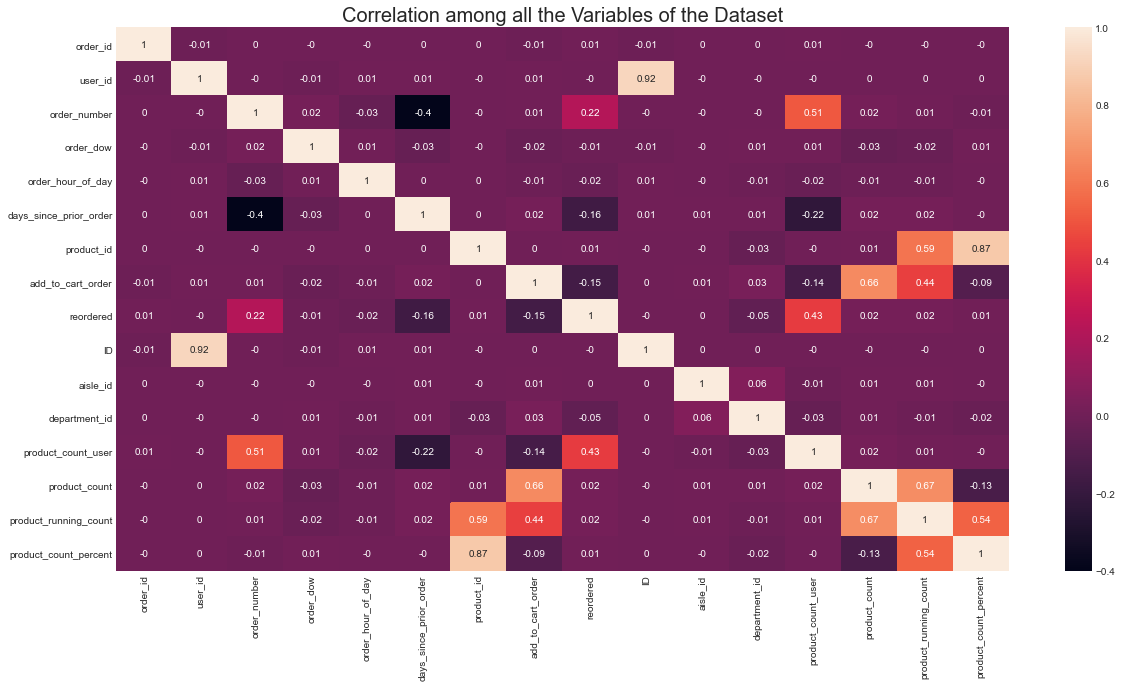

In [112]:
#Correlation among all the Variables of the Dataset
cor=final_train_valid.corr().round(2)
plt.figure(figsize=(20,10), facecolor='w')
sns.heatmap(cor,xticklabels=cor.columns,yticklabels=cor.columns,annot=True)
plt.title("Correlation among all the Variables of the Dataset", size=20)
cor

### Feature Engineering : Using Product Count Feature

In [113]:
#Training Data
tot_train_data=final_train_valid[(final_train_valid.product_count_percent <= 0.7)]
tot_train_data.head(50)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,ID,aisle_id,department_id,product_name,department,aisle,product_count_user,product_count,product_running_count,product_count_percent
0,1187899,1,train,11,4,8,14.0,196,1,1.0,10,77,7,Soda,beverages,soft drinks,10.0,8,1.0,0.125000
1,1187899,1,train,11,4,8,14.0,10258,6,1.0,19,117,19,Pistachios,snacks,nuts seeds dried fruit,9.0,8,2.0,0.250000
2,1187899,1,train,11,4,8,14.0,25133,2,1.0,9,21,16,Organic String Cheese,dairy eggs,packaged cheese,8.0,8,3.0,0.375000
3,1187899,1,train,11,4,8,14.0,26405,4,1.0,119001,54,17,XL Pick-A-Size Paper Towel Rolls,household,paper goods,2.0,8,4.0,0.500000
4,1187899,1,train,11,4,8,14.0,27845,9,0.0,14,84,16,Organic Whole Milk,dairy eggs,milk,0.0,8,5.0,0.625000
8,1492625,2,train,15,1,11,30.0,1757,30,0.0,23,69,15,Organic Cashew Carrot Ginger Soup,canned goods,soup broth bouillon,0.0,23,1.0,0.043478
9,1492625,2,train,15,1,11,30.0,2361,26,0.0,31,37,1,Mint Chip,frozen,ice cream ice,0.0,23,2.0,0.086957
10,1492625,2,train,15,1,11,30.0,5699,22,0.0,39,38,1,Gluten Free Mushroom Risotto Bowl,frozen,frozen meals,0.0,23,3.0,0.130435
11,1492625,2,train,15,1,11,30.0,11913,28,0.0,27,117,19,Shelled Pistachios,snacks,nuts seeds dried fruit,0.0,23,4.0,0.173913
12,1492625,2,train,15,1,11,30.0,12007,15,0.0,54,80,11,Organic All Day Fresh Deodorant Lavender,personal care,deodorants,0.0,23,5.0,0.217391


In [114]:
#Validation data set
tot_valid=final_train_valid[(final_train_valid.product_count_percent > 0.7)]
tot_valid.head(50)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,ID,aisle_id,department_id,product_name,department,aisle,product_count_user,product_count,product_running_count,product_count_percent
5,1187899,1,train,11,4,8,14.0,38928,3,1.0,2,120,16,0% Greek Strained Yogurt,dairy eggs,yogurt,1.0,8,6.0,0.750000
6,1187899,1,train,11,4,8,14.0,39657,5,1.0,21,45,19,Milk Chocolate Almonds,snacks,candy chocolate,1.0,8,7.0,0.875000
7,1187899,1,train,11,4,8,14.0,49235,10,1.0,12,53,16,Organic Half & Half,dairy eggs,cream,2.0,8,8.0,1.000000
24,1492625,2,train,15,1,11,30.0,38547,13,0.0,58,46,19,Bubblegum Flavor Natural Chewing Gum,snacks,mint gum,0.0,23,17.0,0.739130
25,1492625,2,train,15,1,11,30.0,41787,5,1.0,75,24,4,Bartlett Pears,produce,fresh fruits,2.0,23,18.0,0.782609
26,1492625,2,train,15,1,11,30.0,45066,9,1.0,67,24,4,Honeycrisp Apple,produce,fresh fruits,3.0,23,19.0,0.826087
27,1492625,2,train,15,1,11,30.0,45613,18,1.0,48,38,1,Pad Thai,frozen,frozen meals,2.0,23,20.0,0.869565
28,1492625,2,train,15,1,11,30.0,45645,29,0.0,25,3,19,Dark Chocolate Nuts & Sea Salt Bars,snacks,energy granola bars,0.0,23,21.0,0.913043
29,1492625,2,train,15,1,11,30.0,48523,25,0.0,33,37,1,Birthday Cake Light Ice Cream,frozen,ice cream ice,0.0,23,22.0,0.956522
30,1492625,2,train,15,1,11,30.0,48821,27,0.0,29,37,1,Pistachio Ice Cream,frozen,ice cream ice,0.0,23,23.0,1.000000


In [115]:
tot_train_data.shape

(504120, 20)

In [116]:
tot_valid.shape

(283791, 20)

In [117]:
X_train_data=tot_train_data.drop(columns=['eval_set', 'order_id','user_id','ID','product_name','department','aisle','product_count','product_running_count','product_count_percent','reordered'], axis=1)


In [118]:
X_train_data.head()

,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,aisle_id,department_id,product_count_user
0,11,4,8,14.0,196,1,77,7,10.0
1,11,4,8,14.0,10258,6,117,19,9.0
2,11,4,8,14.0,25133,2,21,16,8.0
3,11,4,8,14.0,26405,4,54,17,2.0
4,11,4,8,14.0,27845,9,84,16,0.0


In [119]:
Y_train_data=tot_train_data['reordered']

In [120]:
Y_train_data.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    0.0
Name: reordered, dtype: float64

In [121]:
X_val_data=tot_valid.drop(columns=['eval_set', 'order_id','user_id','ID','product_name','department','aisle','product_count','product_running_count','product_count_percent','reordered'], axis=1)

In [122]:
Y_val_data=tot_valid['reordered']

### Running various ML algorithms on validation data and evaluating accuracy score

### Gaussian

In [123]:
gnb=GaussianNB()
gnb.fit(X_train_data,Y_train_data)

GaussianNB()

In [124]:
pr=gauss_prediction=gnb.predict(X_val_data)

In [125]:
gauss_score=accuracy_score(Y_val_data,pr)

In [126]:
gauss_score

0.9837450800060608

### Logistic Regression

In [127]:
lr=LogisticRegression(max_iter=2000)
lr.fit(X_train_data,Y_train_data)

LogisticRegression(max_iter=2000)

In [128]:
lr_prediction=lr.predict(X_val_data)

In [129]:
lr_score=accuracy_score(Y_val_data,lr_prediction)
lr_score

1.0

### Random Forest

In [130]:
randomforest = RandomForestClassifier(random_state = 1)
randomforest.fit(X_train_data,Y_train_data)

RandomForestClassifier(random_state=1)

In [131]:
randomforest_prediction=randomforest.predict(X_val_data)

In [132]:
randomforest_score=accuracy_score(Y_val_data,randomforest_prediction)
randomforest_score

1.0

### XGBoost

In [133]:
XGBoost = XGBClassifier(random_state = 1)
XGBoost.fit(X_train_data,Y_train_data)

C:\Users\Devansh_21\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:39:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [134]:
XGBoost_prediction=XGBoost.predict(X_val_data)

In [135]:
XGBoost_score=accuracy_score(Y_val_data,XGBoost_prediction)
XGBoost_score

1.0

### Decision tree

In [136]:
decision_tree = tree.DecisionTreeClassifier(random_state = 1)
decision_tree.fit(X_train_data,Y_train_data)

DecisionTreeClassifier(random_state=1)

In [137]:
decision_tree_prediction=decision_tree.predict(X_val_data)

In [138]:
decision_tree_score=accuracy_score(Y_val_data,decision_tree_prediction)
decision_tree_score

1.0

### LightGBM

In [139]:
lgtraindata = lgb.Dataset(tot_train_data.drop(['eval_set', 'order_id','user_id','ID','product_name','department','aisle','product_count','product_running_count','product_count_percent','reordered'], axis=1).to_numpy(), label=tot_train_data['reordered'].to_numpy())
lgvaldata = lgb.Dataset(tot_valid.drop(['eval_set', 'order_id','user_id','ID','product_name','department','aisle','product_count','product_running_count','product_count_percent','reordered'], axis=1).to_numpy(), label=tot_valid['reordered'].to_numpy())

In [140]:
def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True

def run_lgb(depth, leaves):
    params = {
        'objective' : 'binary',
        'boosting_type':'gbdt',
        'num_leaves' : leaves,
        'learning_rate' : 0.02,
        'feature_fraction' : 0.8,
        'bagging_seed' : 42,
        'seed': 42,
        'max_depth': depth, 
        'verbose': 0, 
        'num_boost_round':5000, 
        'early_stopping_rounds':200, 
    }

    evals_result = {}
    model = lgb.train(params, lgtraindata, num_boost_round=params['num_boost_round'], 
                      valid_sets=[lgtraindata, lgvaldata], 
                      early_stopping_rounds=params['early_stopping_rounds'], 
                      verbose_eval=150, 
                      evals_result=evals_result, feval=lgb_f1_score)
    
    return model, evals_result

In [141]:
# running model for depth 5 (and leaves 10)
lgb_5_10, evals_result_5_10 = run_lgb(5,10)

C:\Users\Devansh_21\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\Devansh_21\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Devansh_21\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Devansh_21\Anaconda3\lib\site-packages\

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 200 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[150]	training's binary_logloss: 0.0440837	training's f1: 1	valid_1's binary_logloss: 0.0441691	valid_1's f1: 1
Early stopping, best iteration is:
[14]	training's binary_logloss: 0.487857	training's f1: 1	valid_1's binary_logloss: 0.48798	valid_1's f1: 1


In [142]:
# re-run model without the validation data

def run_lgb_nov(depth, leaves):
    params = {
        'objective' : 'binary',
        'boosting_type':'gbdt',
        'num_leaves' : leaves,
        'learning_rate' : 0.02,
        'feature_fraction' : 0.8,
        'bagging_seed' : 42,
        'seed': 42,
        'max_depth': depth, 
        'verbose': 0, 
        'num_boost_round':5000
    }

    evals_result = {}
    model = lgb.train(params, lgtraindata_full, num_boost_round=params['num_boost_round'])
    
    return model

In [143]:
# full training data
lgtraindata_full = lgb.Dataset(final_train_valid.drop(['eval_set', 'order_id','user_id','ID','product_name','department','aisle','product_count','product_running_count','product_count_percent','reordered'], axis=1).to_numpy(), label=final_train_valid['reordered'].to_numpy())

In [144]:
# running full model for depth 5 (and leaves 10)
lgb_5_10_full = run_lgb_nov(5,10)

C:\Users\Devansh_21\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements


In [145]:
# readying test data
final_test_valid_1 = test_train_final[(test_train_final.reordered != 1.0) & (test_train_final.reordered != 0.0)]
print(final_test_valid_1.shape)

(260664, 17)


In [146]:
final_test_valid_1['product_count_user'].fillna(0,inplace = True)

C:\Users\Devansh_21\Anaconda3\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [155]:
final_test_valid=final_test_valid_1.drop(['eval_set', 'order_id','user_id','product_name','ID','department','aisle','reordered'], axis=1)

In [156]:
final_test_valid.head()

,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,aisle_id,department_id,product_count_user
8,11,4,8,14.0,13032,7,121,14,3.0
9,11,4,8,14.0,26088,8,23,19,2.0
10,11,4,8,14.0,46149,11,77,7,3.0
34,15,1,11,30.0,5450,11,24,4,1.0
35,15,1,11,30.0,7963,2,58,1,1.0


In [157]:
final_test_valid = downcast_dtypes(final_test_valid)
gc.collect()

23

In [158]:
final_test_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260664 entries, 8 to 1048574
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_number            260664 non-null  int8   
 1   order_dow               260664 non-null  int8   
 2   order_hour_of_day       260664 non-null  int8   
 3   days_since_prior_order  260664 non-null  float32
 4   product_id              260664 non-null  int32  
 5   add_to_cart_order       260664 non-null  int8   
 6   aisle_id                260664 non-null  int16  
 7   department_id           260664 non-null  int8   
 8   product_count_user      260664 non-null  float32
dtypes: float32(2), int16(1), int32(1), int8(5)
memory usage: 6.7 MB


In [159]:
# Making predictions
y_test = lgb_5_10_full.predict(final_test_valid.to_numpy())


In [160]:
final_test_valid_2=final_test_valid_1.drop(['eval_set', 'order_id','user_id','product_name','ID','department','aisle','reordered'], axis=1)

### Feature Importance

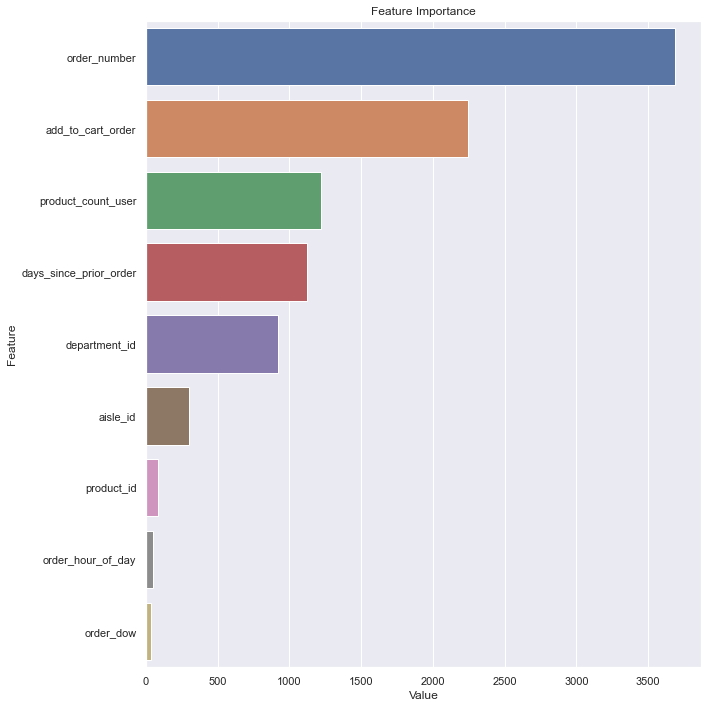

In [161]:
# plot feature importance
feature_imp = pd.DataFrame({'Value':lgb_5_10_full.feature_importance(),'Feature':final_test_valid.columns})
plt.figure(figsize=(10, 10))
sns.set(font_scale = 1)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:30])
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

In [162]:
# converting predictions to pandas dataframe
y_test_pd = pd.DataFrame({'reordered': y_test[:,]})
y_test_pd.head()

,reordered
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0


In [163]:
submission = final_test_valid_1['ID'].reset_index()
submission.head()

,index,ID
0,8,17
1,9,15
2,10,11
3,34,62
4,35,81


In [164]:
submission['reordered']=y_test_pd

In [165]:
submission.loc[submission['reordered'] >=0.5, 'reordered'] = 1
submission.loc[submission['reordered'] < 0.5, 'reordered'] = 0
submission['reordered'].value_counts()

1.0    150993
0.0    109671
Name: reordered, dtype: int64

In [166]:
test_file = order_test[['ID']]
#test_file.head()
final_submission_2 = pd.merge(test_file,submission[['reordered', 'ID']], on=['ID'], how='left')
final_submission_2.head()

,ID,reordered
0,17,1.0
1,11,1.0
2,15,1.0
3,119009,0.0
4,65,0.0


In [170]:
final_submission_3 = final_submission_2[['reordered', 'ID']]
final_submission_3.head()

,reordered,ID
0,1.0,17
1,1.0,11
2,1.0,15
3,0.0,119009
4,0.0,65


In [171]:
final_submission_3.to_csv('submission_4.csv',index=False)